# Useful links
+ [numpy quickstart](https://docs.scipy.org/doc/numpy/user/quickstart.html)
+ [opencv python tutorials](http://docs.opencv.org/3.2.0/d2/d96/tutorial_py_table_of_contents_imgproc.html)
+ [opencv docs(v3)](http://docs.opencv.org/3.2.0/)
+ [opencv docs(v2) c++ & python](http://docs.opencv.org/2.4.13.2/)

In [17]:
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [18]:
image = cv2.imread('images/img2600.jpg')

192

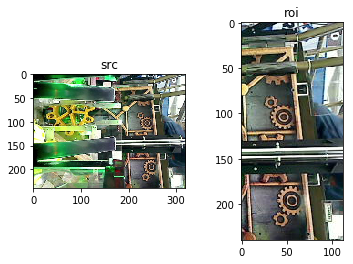

In [19]:
roi = image[0:image.shape[0], 
           int(0.6*image.shape[1]):int(0.95*image.shape[1])]
plt.subplot(1,2,1)
plt.title("src")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.title("roi")
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
int(0.6*image.shape[1])

In [20]:
#inspecting numpy ndarray...
print(f"""
shape: {image.shape}
shape(first 2 dimensions): {image.shape[:2]}
shape(first dimension): {image.shape[0]}
array data type: {image.dtype}
shape type: {type(image.shape)}
roi shape: shape: {roi.shape}
""")


shape: (240, 320, 3)
shape(first 2 dimensions): (240, 320)
shape(first dimension): 240
array data type: uint8
shape type: <class 'tuple'>
roi shape: shape: (240, 112, 3)



In [21]:
threshVal = 200
min = np.array([threshVal,threshVal,threshVal],dtype=np.uint8)
maxVal = np.iinfo(roi.dtype).max
max = np.array([maxVal,maxVal,maxVal],dtype=np.uint8)
# print(min)
# print(max)

# Thresholding

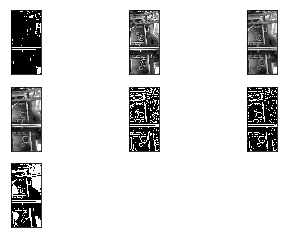

In [22]:
bw = cv2.inRange(roi,min,max)
bw2 = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
bw3 = blur = cv2.GaussianBlur(cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY),(5,5),0)
bwblur = cv2.medianBlur(bw2,5)
th = cv2.adaptiveThreshold(bwblur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,-2)
th2 = cv2.adaptiveThreshold(bwblur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,-5)
ret3,th3 = cv2.threshold(bw3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


images = [bw,bw2,bw3, bwblur,th, th2,th3]

for i in range(len(images)):
    plt.subplot(3,3,i+1),plt.imshow(images[i],'gray')
    plt.xticks([]),plt.yticks([])
plt.show()
#plt.imshow(cv2.cvtColor(bw, cv2.COLOR_GRAY2RGB))

In [23]:
erodeLen =int(0.2 * roi.shape[1] )
erodeKernel = cv2.getStructuringElement(cv2.MORPH_RECT,(erodeLen,3))
erodeMask = np.ones((1,erodeLen), dtype=np.uint8)
#print(erodeKernel)
#print(erodeMask)
#print(erodeKernel)
#print(cv2.transpose(erodeMask))

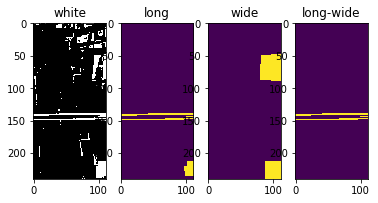

In [24]:
#eroded = cv2.erode(bw,erodeMask,(0,0),iterations=1,borderType=cv2.BORDER_REPLICATE)
eroded =  cv2.morphologyEx(bw, cv2.MORPH_OPEN, erodeMask,(0,0),iterations=1,borderType=cv2.BORDER_REPLICATE)
erodedHoriz = cv2.erode(bw,cv2.transpose(erodeMask))
erodedHoriz = cv2.dilate(erodedHoriz, cv2.getStructuringElement(cv2.MORPH_RECT,(9,9)),iterations=3 )

plt.subplot(1,4,1)
plt.title("white")
plt.imshow(bw, cmap = 'gray')
plt.subplot(1,4,2)
plt.title("long")
plt.imshow(eroded)
plt.subplot(1,4,3)
plt.title("wide")
plt.imshow(erodedHoriz)
plt.subplot(1,4,4)
plt.title("long-wide")
plt.imshow(cv2.subtract(eroded,erodedHoriz))


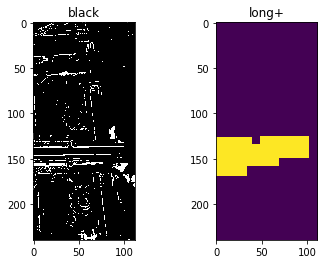

In [25]:

darkRegions = cv2.inRange(roi,(0,0,0),(30,30,30))
darkLongRegions = cv2.erode(darkRegions,erodeMask,(0,0),iterations=1,borderType=cv2.BORDER_REPLICATE)

darkLongRegions = cv2.dilate(darkLongRegions,cv2.getStructuringElement(cv2.MORPH_RECT,(24,24)))
plt.subplot(1,2,1)
plt.title("black")
plt.imshow(darkRegions, cmap = 'gray')
plt.subplot(1,2,2)
plt.title("long+")
plt.imshow(darkLongRegions)

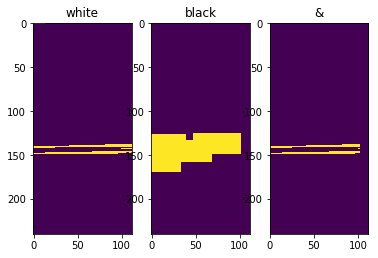

In [32]:


eroded = cv2.subtract(eroded,erodedHoriz)
#eroded = cv2.dilate(eroded,erodeKernel,iterations=1)
boundaries = cv2.bitwise_and(eroded,darkLongRegions)
#boundaries = cv2.dilate(boundaries,erodeMask,iterations=2)

plt.subplot(1,3,1)
plt.title("white")
plt.imshow(eroded)
plt.subplot(1,3,2)
plt.title("black")
plt.imshow(darkLongRegions)
plt.subplot(1,3,3)
plt.title("&")
plt.imshow(boundaries)


[histograms in opencv/python](http://docs.opencv.org/3.2.0/de/db2/tutorial_py_table_of_contents_histograms.html)

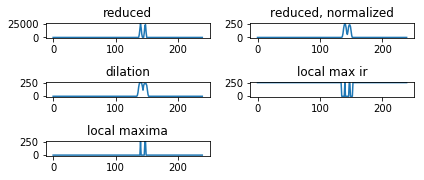

extrema indices: [140 147 148]


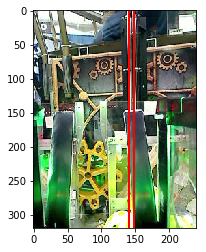

In [40]:
out=np.zeros(240,np.int32)
cv2.reduce(boundaries,1,cv2.REDUCE_SUM, dst=out, dtype=cv2.CV_32S)

lowpass = cv2.blur(out,(1,5))

normalized = lowpass.copy()
normalized = cv2.normalize(lowpass,normalized,0,255,norm_type=cv2.NORM_MINMAX, dtype = cv2.CV_8U)

thresh = cv2.threshold(normalized,200,255,cv2.THRESH_BINARY)[1]

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT,(1,3),(-1,-1))
dilated = cv2.dilate(normalized,structuringElement)

localMax = cv2.compare(normalized,dilated,cv2.CMP_EQ)

localMax2 = cv2.bitwise_and(localMax, thresh)

overlayImg = image.copy()
for index in np.nonzero(localMax2)[0]:
    cv2.line(overlayImg,(0,index),(overlayImg.shape[1],index),(0,0,255),2)
   


nRows = 5
nCols = 2;
plt.subplot(nRows,nCols,1)
plt.title('reduced')

plt.plot(out)
plt.subplot(nRows,nCols,2)
plt.title('reduced, normalized')
plt.plot(normalized)
plt.subplot(nRows,nCols,3)
plt.title('dilation')
plt.plot(dilated)
plt.subplot(nRows,nCols,4)
plt.title('local max ir')
plt.plot(localMax)
plt.subplot(nRows,nCols,5)
plt.title('local maxima')
plt.plot(localMax2)
plt.tight_layout()
plt.show()
plt.imshow(cv2.cvtColor(cv2.flip(cv2.transpose(overlayImg),0),cv2.COLOR_BGR2RGB)) 
#localMax2
#(array([114, 122]), array([0, 0]))          
#np.nonzero(localMax2)[0]
#array([114, 122])
#cv2.format(np.nonzero(localMax2),cv2.FMT_DEFAULT)
print("extrema indices: "+str(np.nonzero(localMax2)[0]))


In [28]:
print(f"sorted nonzero values: {np.trim_zeros(np.sort(out))} ")
print(f"nonzero indices: {np.nonzero(out)[0]} " )
print(f"nonzero values: {str(out[np.nonzero(out)])}")

sorted nonzero values: [ 8160 11985 13005 15300 16575 23205 23715 28560 28560 28560] 
nonzero indices: [138 139 140 141 142 143 146 147 148 149] 
nonzero values: [13005 23205 28560 23715 11985  8160 16575 28560 28560 15300]


In [29]:
from scipy.signal import argrelextrema
localExtremaIndices = argrelextrema(out,np.greater)[0]
print(localExtremaIndices)
print(out[localExtremaIndices])
print('-----')
localExtremaIndices = argrelextrema(lowpass,np.greater)[0]
print(localExtremaIndices)
print(lowpass[localExtremaIndices])

[140]
[28560]
-----
[140]
[[20094]]


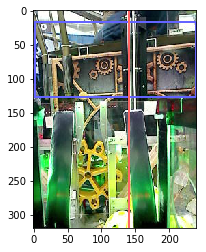

In [30]:
overlayImg = image.copy()
cv2.rectangle(overlayImg,(int(0.6*image.shape[1]),2),
                    ( int(0.95*image.shape[1])-2, image.shape[0]-2),
                    (255,100,100),2)
for index in localExtremaIndices:
    cv2.line(overlayImg,(0,index),(image.shape[1],index),(100,100,255),2)
   
overlayImg = np.rot90(overlayImg)
plt.imshow(cv2.cvtColor(overlayImg,cv2.COLOR_BGR2RGB))    

[[[  0 140 111 140]]

 [[  0 148 111 148]]

 [[  0 147 111 147]]

 [[ 21 139 111 139]]

 [[  0 141  92 141]]

 [[ 47 146 111 146]]]


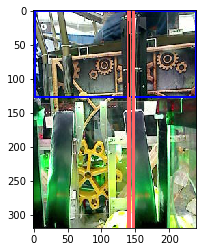

In [31]:
lines = cv2.HoughLinesP(boundaries,1,np.pi/2,60,minLineLength=60,maxLineGap=40)
print(lines)
imgWithLines = image.copy()
#int(0.6*image.shape[1]):image.shape[1]
cv2.rectangle(imgWithLines,(int(0.6*image.shape[1]),2),
                    (image.shape[1]-2, image.shape[0]-2),
                    (255,0,0),2)
if lines is not None:
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv2.line(imgWithLines,(0,y1),(imgWithLines.shape[1],y2),(100,100,255),2)
        cv2.line(imgWithLines,(int(0.6*image.shape[1]) + x1,y1),(int(0.6*image.shape[1]) + x2,y2), (int(1*x1),int(2*x1),int(4*x1)),1)
    
imgWithLines = np.rot90(imgWithLines) 
plt.imshow(cv2.cvtColor(imgWithLines,cv2.COLOR_BGR2RGB))

# c++ code
```C++
 // cv::Mat src = cv::imread("img2700.jpg");
    int start =  0.6*src.cols;
   // printf("start: %d",start);
   // cv::Rect roiRect(start,0,src.cols - start,src.rows);
    cv::Mat roi = cv::Mat(src, cv::Range::all(), cv::Range(start,src.cols));
  //  printf("roi channels: %d\n",roi.channels());
    cv::Mat bw;
    int thresh = 160;
    cv::inRange(roi, cv::Scalar(thresh,thresh,thresh), cv::Scalar(255,255,255), bw);
    
    
    int len =  0.1*(double)(roi.cols);
    //printf("len: %d",len);
    
    
    cv::Mat erodeMask =  cv::getStructuringElement(cv::MORPH_RECT, cv::Size(len,1));
    cv::Mat hErodeMask;
    cv::transpose(erodeMask, hErodeMask);
    cv::Mat eroded, erodedHoriz,erodedHoriz2;
    
    cv::morphologyEx(bw, eroded, cv::MorphTypes::MORPH_OPEN, erodeMask,cv::Point(0,0),1,cv::BorderTypes::BORDER_REPLICATE);
    //cv::erode(bw, eroded, erodeMask);
    cv::erode(bw,erodedHoriz,hErodeMask);
    cv::dilate(erodedHoriz, erodedHoriz2, cv::getStructuringElement(cv::MORPH_RECT, cv::Size(9,9)),cv::Point(-1,-1),3);

    cv::subtract(eroded, erodedHoriz2, eroded);
    
    cv::Mat dark, darkLong;
    cv::inRange(roi, cv::Scalar::zeros(), cv::Scalar(50,50,50), dark);
    cv::morphologyEx(dark, darkLong, cv::MorphTypes::MORPH_OPEN, erodeMask,cv::Point(0,0),1,cv::BorderTypes::BORDER_REPLICATE);
    cv::dilate(darkLong,darkLong,cv::getStructuringElement(cv::MORPH_RECT,cv::Point(24,24)),cv::Point(-1,-1),2);
    

    cv::Mat ld;
    cv::bitwise_and(eroded, darkLong, ld);
    cv::dilate(ld, ld, erodeMask);

    cv::Mat sums;
    
    cv::reduce(ld, sums, 1, cv::ReduceTypes::REDUCE_AVG,CV_32S);
    
    
    cv::Mat something(sums.size(),CV_64F);
    sums.convertTo(something, CV_64F);
    
    
    cv::Mat smoothed;
    cv::blur(sums, smoothed, cv::Size(1,3));
    
    cv::Size size = smoothed.size();
    cv::Mat normalized(size,CV_8U);
    
    cv::normalize(smoothed, normalized, 0,255.0, cv::NormTypes::NORM_MINMAX,CV_8U);
    
    cv::Mat normThresh(size,CV_8U);
    
    cv::Mat plotImg;
    cv::plot::createPlot2d(something)->render(plotImg);
    cv::imshow("IR", plotImg);

    
    cv::threshold(normalized, normThresh, 10, 255, cv::ThresholdTypes::THRESH_BINARY);
    cv::Mat dilated;
    
    cv::dilate(normThresh, dilated, cv::getStructuringElement(cv::MorphShapes::MORPH_RECT, cv::Size(1,3)));
    
    cv::Mat localMax;
    cv::compare(normalized, dilated, localMax, cv::CmpTypes::CMP_EQ);
    cv::Mat localMax2;
    cv::bitwise_and(localMax, normThresh, localMax2);
    
    
    std::vector<cv::Point> maxima;
    
    cv::findNonZero(localMax2, maxima);
    
    std::cout << "maxima: "<<maxima<<std::endl;

    int sum=0;

    for (cv::Point max : maxima ) {
      cv::line(src, cv::Point(0       , max.y),
                    cv::Point(src.cols, max.y),
                    cv::Scalar(0,0,255),2);
        sum+=max.y;
    }
    if(!maxima.empty()) sum /= maxima.size();
    
    cv::line(src, cv::Point(0 , sum), cv::Point(src.cols, sum), cv::Scalar(255,100,100));

    
    cv::transpose(src, src);
    cv::flip(src, src, 0);

```
